<a href="https://colab.research.google.com/github/wandiab/PINNs_BuckleyLeverett/blob/main/BuckleyLeverett_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
# Installing Packages

!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install pyDOE

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 ghostscript libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java
  libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-framework-java libcommons-logging-java-doc
  li

In [4]:
# Imports
import sys
import json
import os
import tensorflow as tf
import numpy as np
import tensorflow.experimental.numpy as tnp
import tensorflow_probability as tfp
import scipy
from scipy import io
import random
import scipy.io
import time
from datetime import datetime
from pyDOE import lhs
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

# Manually making sure the numpy random seeds are "the same" on all devices
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

Plotting and Logger

In [13]:
mpl.use('pgf')

def figsize(scale, nplots = 1):
    fig_width_pt = 690.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 8,               # LaTeX default is 10pt font.
    "font.size": 8,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots), dpi=300)
    ax = fig.add_subplot(111)
    return fig, ax

def plot_inf_cont_results(X_star, u_pred, X_u_train, u_train, Exact_u, X, T, x, t):

  # Interpolating the results on the whole (x,t) domain.
  # griddata(points, values, points at which to interpolate, method)
  U_pred = griddata(X_star, u_pred, (X, T), method='cubic')

  # Creating the figures
  fig, ax = newfig(1.0, 1.1)
  ax.axis('off')

  # ####### Row 0: u(t,x) ##################
  # gs0 = gridspec.GridSpec(1, 2)
  # gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
  # #ax = plt.subplot(gs0[:, :])
  # ax = fig.add_subplot(gs0[:, :])


  # h = ax.imshow(U_pred.T, interpolation='nearest', cmap='viridis',
  #               extent=[t.min(), t.max(), x.min(), x.max()],
  #               origin='lower', aspect='auto')
  # divider = make_axes_locatable(ax)
  # cax = divider.append_axes("right", size="5%", pad=0.05)
  # fig.colorbar(h, cax=cax)

  # ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

  # line = np.linspace(x.min(), x.max(), 2)[:,None]
  # ax.plot(t[10]*np.ones((2,1)), line, 'r--', linewidth = 1)
  # ax.plot(t[25]*np.ones((2,1)), line, 'r--', linewidth = 1)
  # ax.plot(t[40]*np.ones((2,1)), line, 'r--', linewidth = 1)
  # ax.plot(t[55]*np.ones((2,1)), line, 'r--', linewidth = 1)
  # ax.plot(t[70]*np.ones((2,1)), line, 'r--', linewidth = 1)
  # ax.plot(t[90]*np.ones((2,1)), line, 'r--', linewidth = 1)

  # ax.set_xlabel('$t$')
  # ax.set_ylabel('$x$')
  # ax.legend(frameon=False, loc = 'best')
  # ax.set_title('$u(t,x)$', fontsize = 5)

  ####### Row 1: u(t,x) slices ##################
  gs1 = gridspec.GridSpec(2, 5)
  gs1.update(top=1-1/4, bottom=0.2, left=0.1, right=0.9, wspace=0.5)

  ax = plt.subplot(gs1[0, 0])
  ax.plot(x,Exact_u[10,:], color='blue', linewidth = 1.5, label = 'Exact')
  ax.plot(x,U_pred[10,:], 'r--', linewidth = 1.5, label = 'Prediction')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')
  ax.set_title('$t = 0.10$', fontsize = 7)
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])

  ax = plt.subplot(gs1[0, 1])
  ax.plot(x,Exact_u[25,:], color='blue', linewidth = 1.5, label = 'Exact')
  ax.plot(x,U_pred[25,:], 'r--', linewidth = 1.5, label = 'Prediction')
  ax.set_title('$t = 0.25$', fontsize = 7)
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])

  ax = plt.subplot(gs1[0, 2])
  ax.plot(x,Exact_u[40,:], color='blue', linewidth = 1.5, label = 'Exact')
  ax.plot(x,U_pred[40,:], 'r--', linewidth = 1.5, label = 'Prediction')
  ax.set_title('$t = 0.40$', fontsize = 7)
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])

  ax = plt.subplot(gs1[1, 0])
  ax.plot(x,Exact_u[55,:], color='blue', linewidth = 1.5, label = 'Exact')
  ax.plot(x,U_pred[55,:], 'r--', linewidth = 1.5, label = 'Prediction')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])
  ax.set_title('$t = 0.55$', fontsize = 7)
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

  ax = plt.subplot(gs1[1, 1])
  ax.plot(x,Exact_u[70,:], color='blue', linewidth = 1.5, label = 'Exact')
  ax.plot(x,U_pred[70,:], 'r--', linewidth = 1.5, label = 'Prediction')
  ax.set_title('$t = 0.70$', fontsize = 7)
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])

  ax = plt.subplot(gs1[1, 2])
  ax.plot(x,Exact_u[90,:], color='blue', linewidth = 1.5, label = 'Exact')
  ax.plot(x,U_pred[90,:], 'r--', linewidth = 1.5, label = 'Prediction')
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])
  ax.set_title('$t = 0.90$', fontsize = 7)

  plt.show();

class Logger(object):
  def __init__(self, frequency=20):
    print("TensorFlow version: {}".format(tf.__version__))
    print("Eager execution: {}".format(tf.executing_eagerly()))
    print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

    self.start_time = time.time()
    self.frequency = frequency

  def __get_elapsed(self):
    return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

  def __get_error_u(self):
    return self.error_fn()

  def set_error_fn(self, error_fn):
    self.error_fn = error_fn

  def log_train_start(self, model):
    print("\nTraining started")
    print("================")

  def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
    if epoch % self.frequency == 0:
      print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e} " + custom)

  def log_train_opt(self, name):
    print(f"—— Starting {name} optimization ——")

  def log_train_end(self, epoch, custom=""):
    print("==================")
    print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  error = {self.__get_error_u():.4e}  " + custom)

# Prep Data

In [6]:
def prep_data(path, N_u=None, N_f=None):
    # Reading external data [t is 100x1, usol is 256x100 (solution), x is 256x1]
    #data = scipy.io.loadmat(path)
    data = path
    # Flatten makes [[]] into [], [:,None] makes it a column vector
    t = data['t'].flatten()[:,None] # T x 1
    x = data['x'].flatten()[:,None] # N x 1

    # Keeping the 2D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
    Exact_u = np.real(data['usol']).T # T x N

    # Meshing x and t in 2D (256,100)
    X, T = np.meshgrid(x,t)

    # Preparing the inputs x and t (meshed as X, T) for predictions in one single array, as X_star
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

    # Preparing the testing u_star
    u_star = Exact_u.flatten()[:,None]

    # Noiseless data TODO: add support for noisy data
    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]

    # Domain bounds (lowerbounds upperbounds) [x, t], which are here ([-1.0, 0.0] and [1.0, 1.0])
    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0)
    # Getting the initial conditions (t=0)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact_u[0:1,:].T
    # Getting the lowest boundary conditions (x=0)
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact_u[:,0:1]

    # Stacking them in multidimensional tensors for training (X_u_train is for now the continuous boundaries)
    X_u_train = np.vstack([xx1, xx2])
    u_train = np.vstack([uu1, uu2])

    # Generating the x and t collocation points for f, with each having a N_f size
    # We pointwise add and multiply to spread the LHS over the 2D domain
    X_f_train = lb + (ub-lb)*lhs(2, N_f)

    # Generating a uniform random sample from ints between 0, and the size of x_u_train, of size N_u (initial data size) and without replacement (unique)
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    # Getting the corresponding X_u_train (which is now scarce boundary/initial coordinates)
    X_u_train = X_u_train[idx,:]
    # Getting the corresponding u_train
    u_train = u_train [idx,:]

    return x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f_train, ub, lb

# HYPER PARAMETERS

In [7]:
# Data size on the solution u
N_u = 300
# Collocation points size, where we’ll check for f = 0
N_f = 10000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 1
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate= 0.011,
  beta_1=0.9,
  epsilon=1e-1)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 1 #This number is not important as long as it is not 0, as LBGFS optimizer will run until convergence

# Physics Informed NN

In [8]:
class PhysicsInformedNN(object):
  def __init__(self, layers, optimizer, logger, X_f, ub, lb):

    # Descriptive Keras model [2, 20, …, 20, 1]
    self.u_model = tf.keras.Sequential()
    self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.u_model.add(tf.keras.layers.Lambda(
      lambda X: 1.0*(X - lb)/(ub - lb) - 0.0))
    for width in layers[1:]:
        self.u_model.add(tf.keras.layers.Dense(
          width, activation=tf.nn.tanh,
          kernel_initializer='glorot_normal'))

    # Computing the sizes of weights/biases for future decomposition
    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    self.optimizer = optimizer
    self.logger = logger

    self.dtype = tf.float32

    # Separating the collocation coordinates
    self.x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
    self.t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)

  # Defining custom loss
  @tf.function
  def __loss(self, u, u_pred):
    f_pred, weight_resd1 = self.f_model()
    return tf.reduce_mean(tf.square(u - u_pred)) + tf.reduce_mean(tf.square(f_pred))

  @tf.function
  def __grad(self, X, u):
    with tf.GradientTape() as tape:
      loss_value = self.__loss(u, self.u_model(X))
    return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

  def __wrap_training_variables(self):
    var = self.u_model.trainable_variables
    return var

  # The actual PINN
  @tf.function
  def f_model(self):
    #here u is the S (saturation function)
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(self.x_f)
      tape.watch(self.t_f)
      X_f = tf.stack([self.x_f[:,0], self.t_f[:,0]], axis=1)
      u = self.u_model(X_f)

      Swc = 0.0
      M = 2
      Sor = 0.0

      #Non-Convex Flux Function
      frac_org = tf.divide(tf.square(u-Swc), tf.square(u-Swc) + tf.divide(tf.square(1 - u - Sor), M))
      Sf = tf.sqrt(tf.divide(1/M, (1/M)+1))
      frac_Sf = tf.divide(tf.square(Sf-Swc), tf.square(Sf-Swc) + tf.divide(tf.square(1 - Sf - Sor), M))
      frac = tf.divide(frac_Sf, Sf)*u - tf.multiply(tf.divide(frac_Sf, Sf)*u, tnp.heaviside(u-Sf, 1)) + tf.multiply(frac_org, tnp.heaviside(u-Sf, 1))

    u_x = tape.gradient(u, self.x_f)
    u_t = tape.gradient(u, self.t_f)
    frac_u = tape.gradient(frac, u)
    weight_resd = tf.divide(1, (tf.square(u_t) + tf.square(u_x) + 1))

    del tape

    return u_t + frac_u * u_x, weight_resd

  def get_weights(self):
    w = []
    for layer in self.u_model.layers[1:]:
      weights_biases = layer.get_weights()
      weights = weights_biases[0].flatten()
      biases = weights_biases[1]
      w.extend(weights)
      w.extend(biases)
    return tf.convert_to_tensor(w, dtype=self.dtype)

  def set_weights(self, w):
    for i, layer in enumerate(self.u_model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)

  # The training function
  def fit(self, X_u, u, tf_epochs):
    self.logger.log_train_start(self)

    # Creating the tensors
    X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
    u = tf.convert_to_tensor(u, dtype=self.dtype)

    self.logger.log_train_opt("Adam")
    for epoch in range(tf_epochs):
      # Optimization step
      loss_value, grads = self.__grad(X_u, u)
      self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
      self.logger.log_train_epoch(epoch, loss_value)

    self.logger.log_train_opt("LBFGS")
    def loss_and_flat_grad(w):
      with tf.GradientTape() as tape:
        self.set_weights(w)
        loss_value = self.__loss(u, self.u_model(X_u))
      grad = tape.gradient(loss_value, self.u_model.trainable_variables)
      grad_flat = []
      for g in grad:
        grad_flat.append(tf.reshape(g, [-1]))
      grad_flat =  tf.concat(grad_flat, 0)

      return loss_value, grad_flat

    tfp.optimizer.lbfgs_minimize(
      loss_and_flat_grad,
      initial_position=self.get_weights(),
      num_correction_pairs=100,
      max_iterations=50000,
      f_relative_tolerance= 1.0e-16*np.finfo(float).eps,
      tolerance= 1.0e-16*np.finfo(float).eps,
      parallel_iterations=100)

    self.logger.log_train_end(tf_epochs + 1)

  def predict(self, X_star):
    u_star = self.u_model(X_star)
    return u_star


# Training

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.18.0
Eager execution: True
GPU-accerelated: True


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



Training started
—— Starting Adam optimization ——
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tf_epoch =      0  elapsed = 00:07  loss = 1.1985e+00 
—— Starting LBFGS optimization ——
Training finished (epoch 2): duration = 10:09  error = 3.0645e-02  


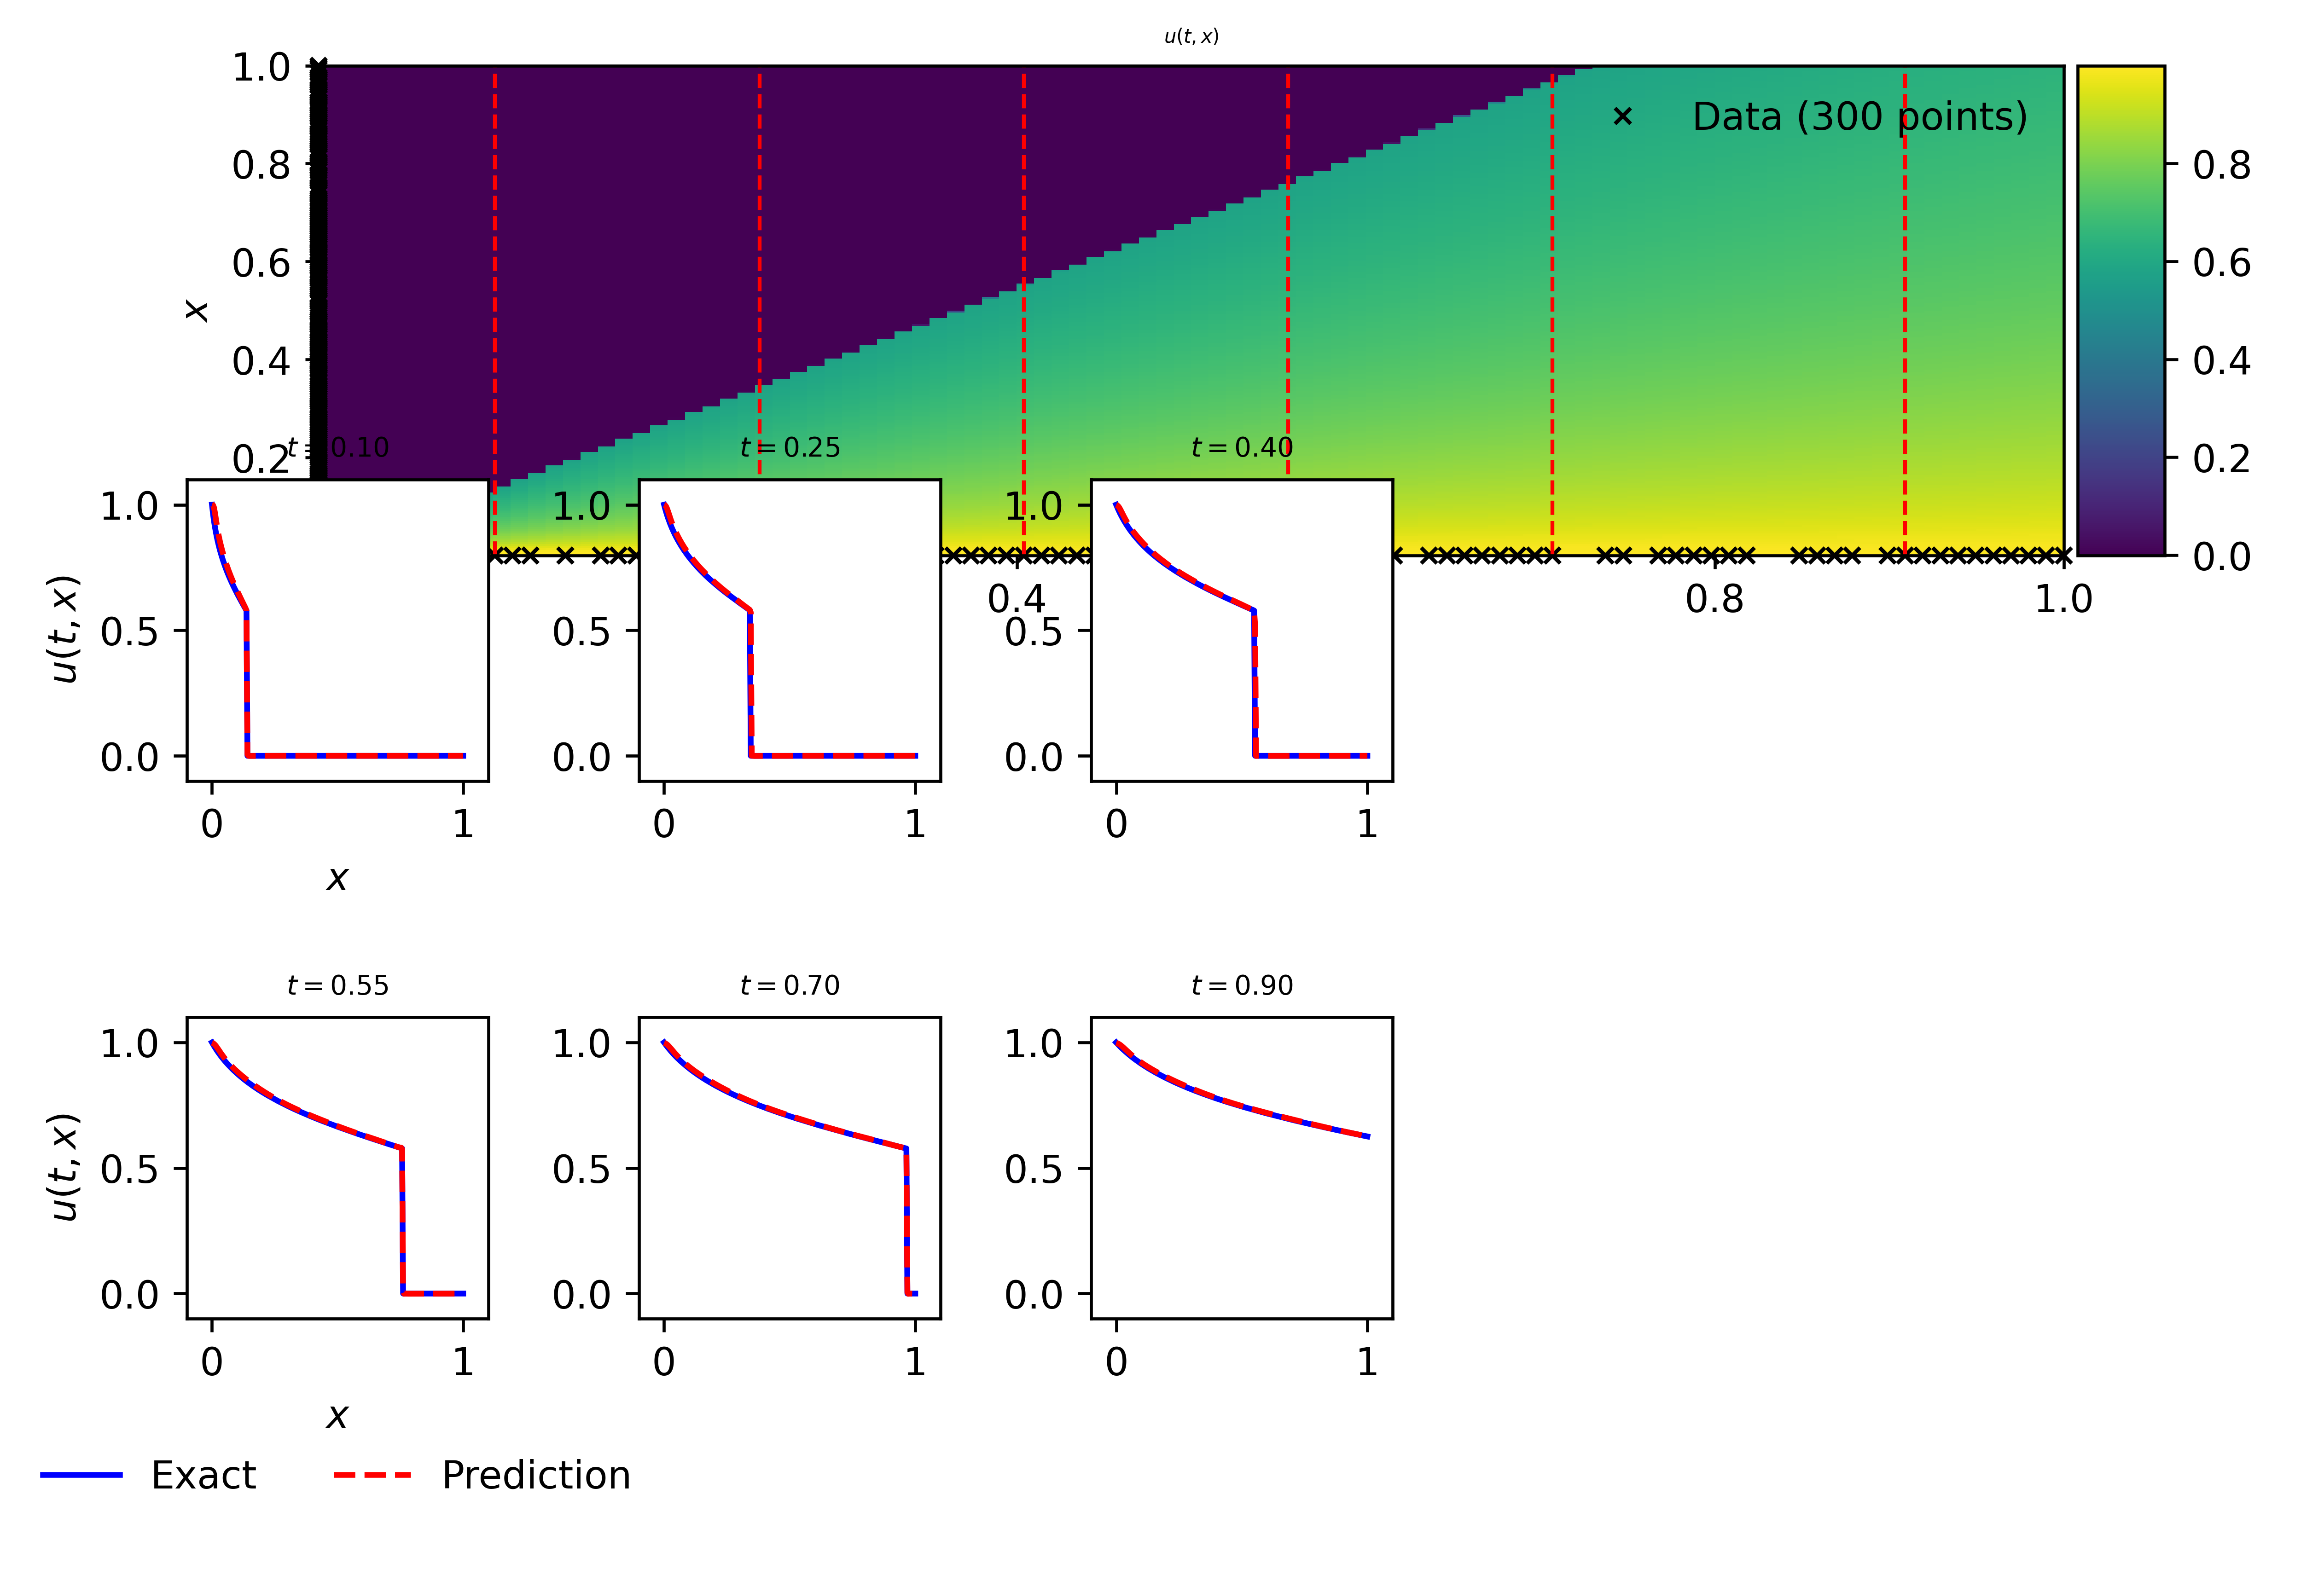

In [9]:
# Getting the data
path = scipy.io.loadmat('/content/Buckley_Swc_0_Sor_0_M_2.mat');
x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f, ub, lb = prep_data(path, N_u, N_f)

# Creating the model and training
logger = Logger(frequency=200)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, X_f, ub, lb)
def error():
  u_pred = pinn.predict(X_star)
  return np.linalg.norm(u_star - u_pred) / np.linalg.norm(u_star)
logger.set_error_fn(error)

pinn.fit(X_u_train, u_train, tf_epochs)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_pred = pinn.predict(X_star)

#Plotting
plot_inf_cont_results(X_star, u_pred.numpy().flatten(), X_u_train, u_train, Exact_u, X, T, x, t)

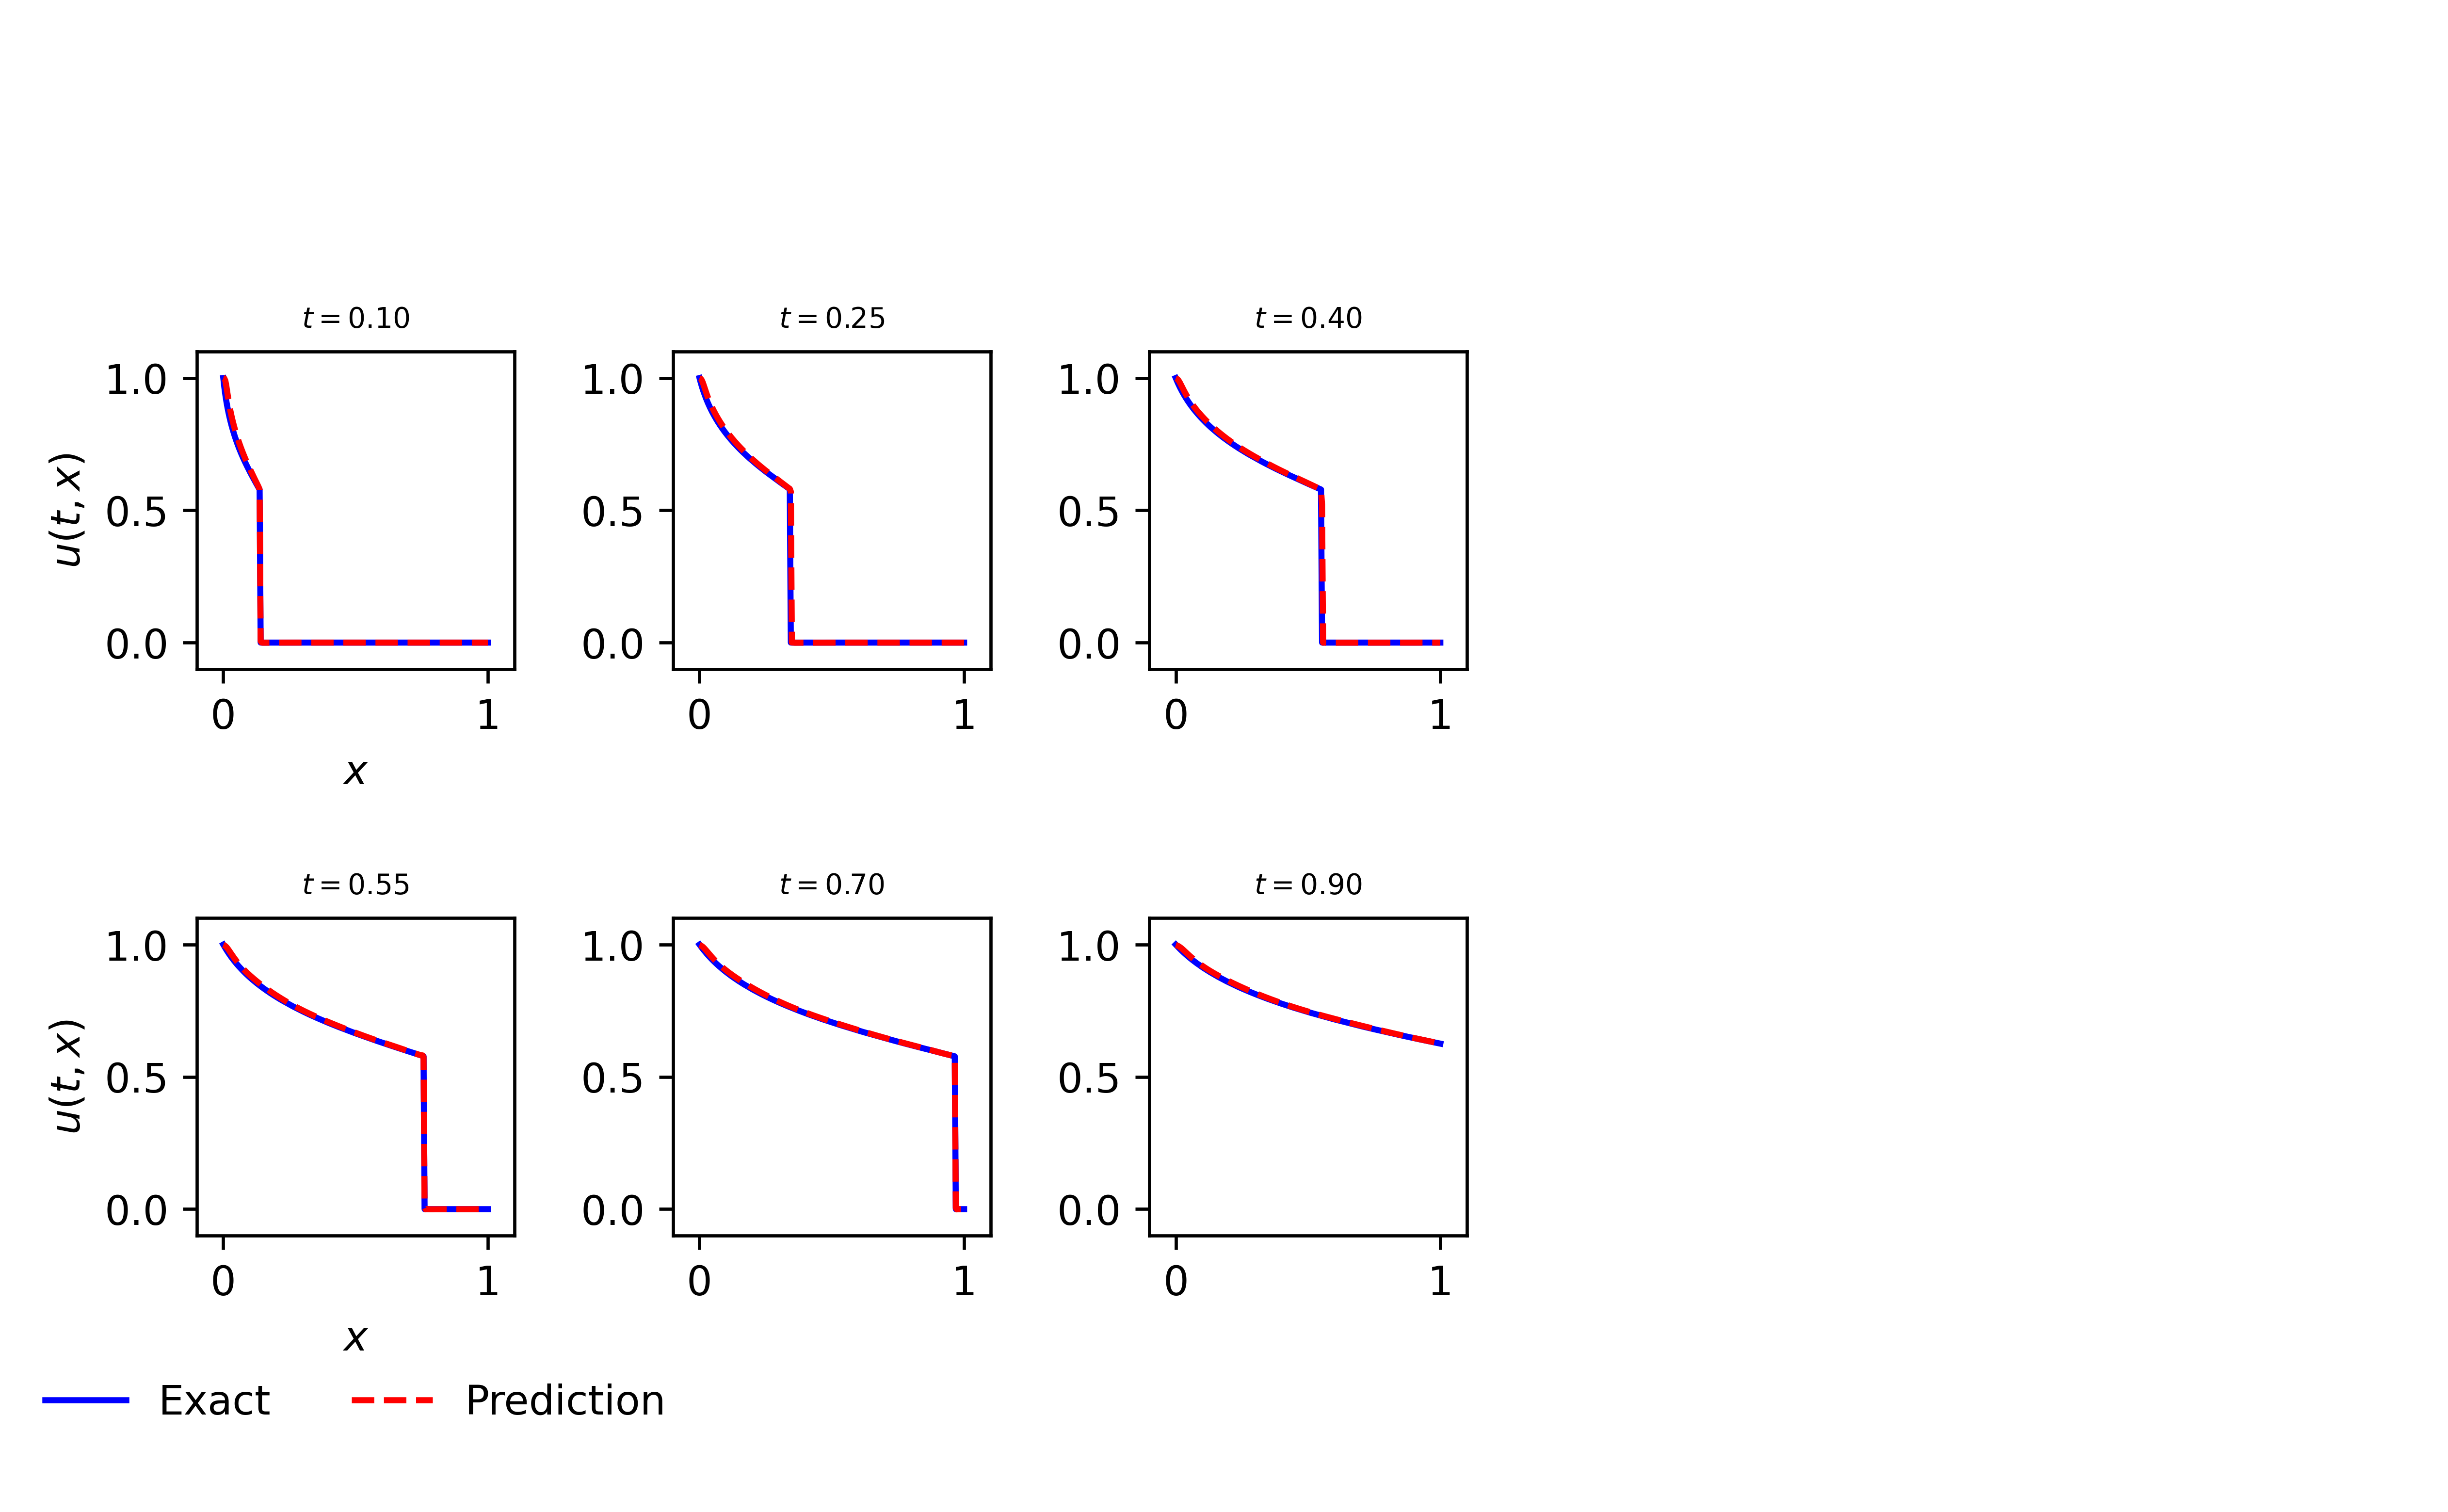

In [14]:
plot_inf_cont_results(X_star, u_pred.numpy().flatten(), X_u_train, u_train, Exact_u, X, T, x, t)